In [20]:
import numpy as np
from tqdm import tqdm
from time import time
import cv2

def get_extractable_cells(mask: np.ndarray, scale=1) -> np.ndarray:
    
    mask = cv2.resize(mask, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    
    mask_values = np.unique(mask)
    
    centers = []  
    for n in tqdm(mask_values):
        
        if n == 0:
            continue
        
        x_idx, y_idx = np.where(mask == n)
        x_min, x_max = x_idx.min()/scale, x_idx.max()/scale
        y_min, y_max = y_idx.min()/scale, y_idx.max()/scale
        
        centers.append([(x_min + x_max)//2, (y_min + y_max)//2, n])
    
        # cell = tmp[y_min:y_max, x_min:x_max]
        # y, x = calc_center(cell)
        # y_center, x_center = np.round(y+y_min,0), np.round(x+x_min,0)
        # centers.append([y_center, x_center, n])
        
    return np.array(centers).astype(np.uint16)

In [21]:
def dist_2d(p0, p1):
    
    return np.linalg.norm(p0-p1)
    

100%|██████████| 1214/1214 [00:01<00:00, 1119.70it/s]


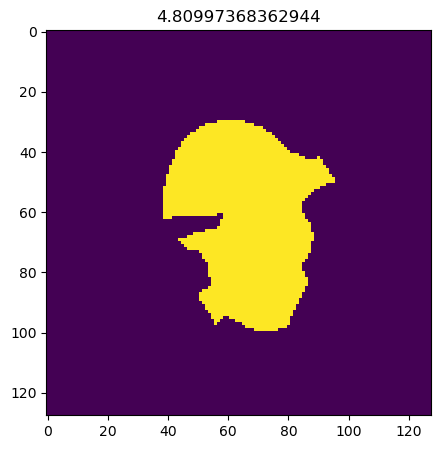

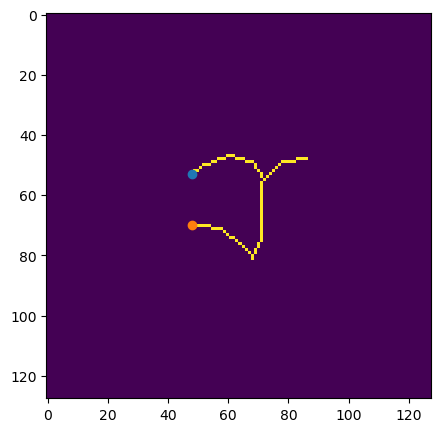

In [30]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import tifffile
import numpy as np
import networkx as nx
from skan.csr import skeleton_to_csgraph
import itertools
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fil_finder import FilFinder2D
import astropy.units as u

from scipy.sparse import csgraph

plt.rcParams['figure.figsize'] = 5,5

mask = tifffile.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/to_delete/test/20220525_20220223_06-2847_BM_ROI003_full_masks.tif").astype(np.uint16)
centers = get_extractable_cells(mask, scale=0.125)

i=0
metrics = []
for c in centers:
    
    #plt.imshow(mask); plt.show()
    if c[2] == 211:
        i+=1
        start_idx_x = c[0] - 64 if c[0] > 64 else 0
        end_idx_x = c[0] + 64 if c[0] < mask.shape[0]-64 else mask.shape[0]
        
        start_idx_y = c[1] - 64 if c[1] > 64 else 0
        end_idx_y = c[1] + 64 if c[1] < mask.shape[1]-64 else mask.shape[1]
        
        im = mask[start_idx_x:end_idx_x, start_idx_y:end_idx_y].copy()
        im[im!=c[2]] = 0
        im = (im/im.max()*255).astype(np.uint8)
        #im = im.astype(bool)

        skeleton = skeletonize(im, method="lee").astype(float)

        from skan.csr import skeleton_to_csgraph
        from skan import draw
        from skan import Skeleton, summarize

        pixel_graph, coordinates = skeleton_to_csgraph(skeleton)
        
        if len(coordinates[0]) == 1:
            metrics.append([*c, 1])
            continue
        

        branch_data = summarize(Skeleton(skeleton, spacing=1), find_main_branch=True)
        
        longest_path = branch_data["branch-distance"][branch_data["main"]].sum()
        
        if not any(branch_data["main"]):
            metrics.append([*c, 1])
            continue
        
        a = list(branch_data["node-id-src"][branch_data["main"]])
        b = list(branch_data["node-id-dst"][branch_data["main"]])

        d = [*a ,*b]
        p = [i for i in d if d.count(i) == 1]

        p0 = np.array([coordinates[0][p[0]], coordinates[1][p[0]]])
        p1 = np.array([coordinates[0][p[1]], coordinates[1][p[1]]])
        
        image_dist = dist_2d(p0, p1)
        
        # print(c)
        # print(start_idx_x, end_idx_x, start_idx_y,end_idx_y)
        # print("image_dist  :", image_dist, "longest_path   :", longest_path)
        # fig, ax = plt.subplots(1, 1, figsize=(10,10))
        # draw.overlay_skeleton_networkx(pixel_graph, np.transpose(coordinates), image=skeleton, axis=ax, font_size=8)
        # plt.show()

        plt.imshow(im)
        plt.title(longest_path / image_dist); plt.show()
        plt.imshow(skeleton)
        plt.scatter(p0[1], p0[0])
        plt.scatter(p1[1], p1[0])
        plt.show()
        
        metrics.append([*c, longest_path / image_dist])
    

In [9]:
metrics = np.array(metrics)

vals = metrics[:, -1]

perc = np.percentile(vals, 99)
vals = np.clip(vals, 0, perc)

metrics[:, -1] = vals

In [10]:
colored_mask = np.zeros_like(mask).astype(float)
for x,y,c, val in metrics:
    colored_mask[mask == c] = val

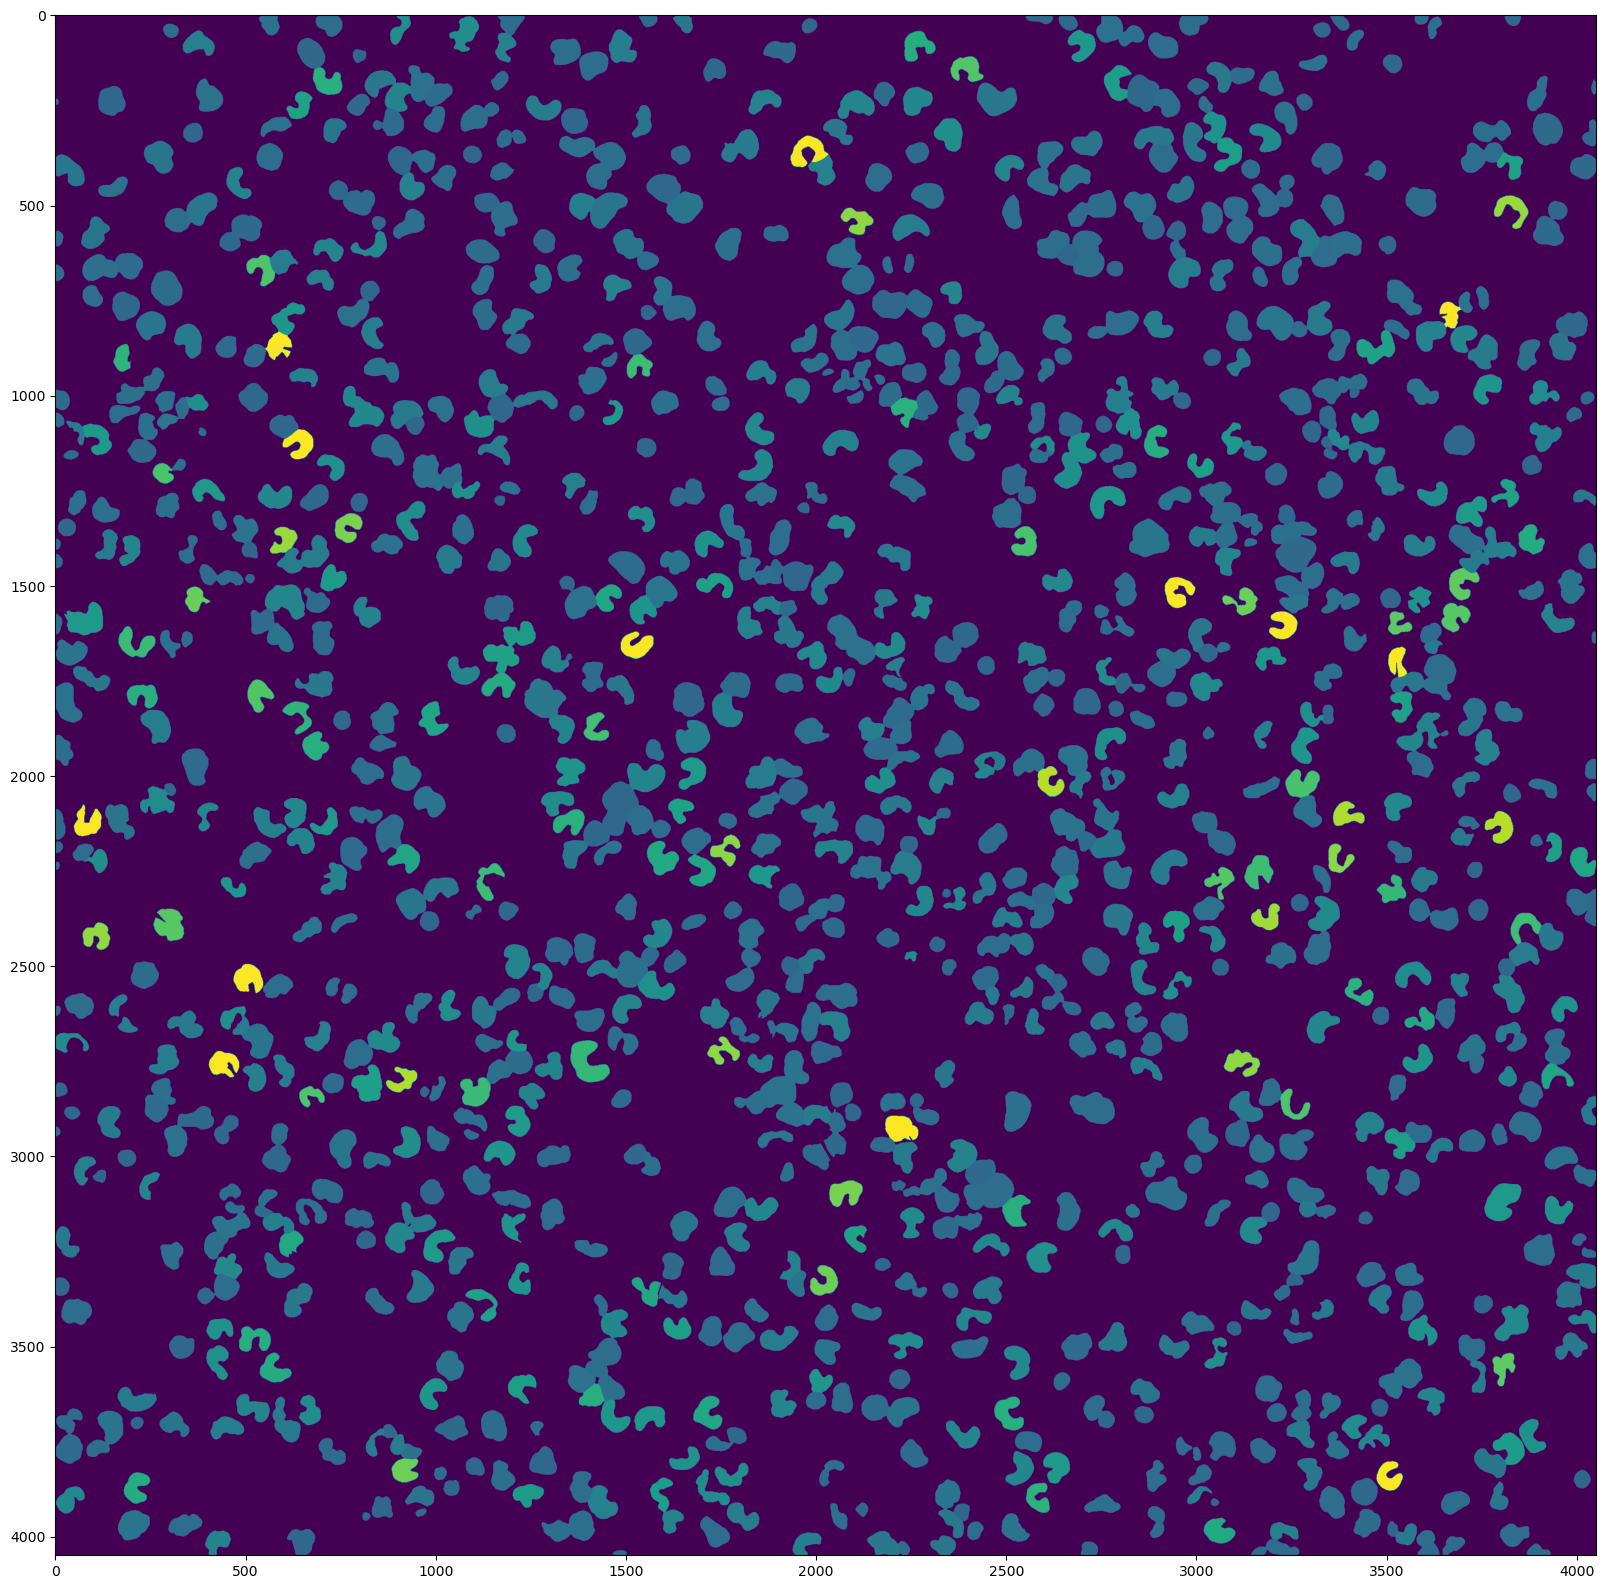

In [11]:
plt.rcParams['figure.figsize'] = 20,20

tifffile.imwrite("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/to_delete/overlay.tif",(colored_mask/colored_mask.max()*255).astype(np.uint8))

plt.imshow(colored_mask, vmin=0, vmax=3)

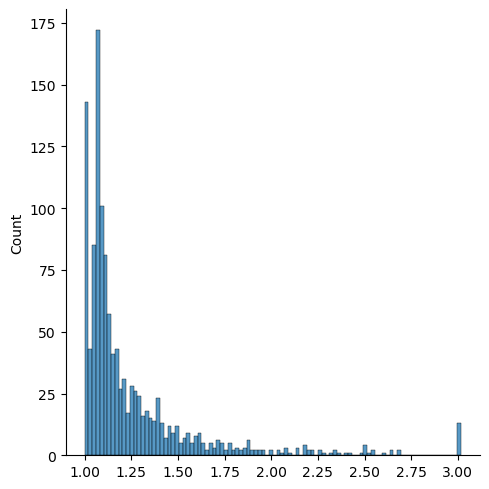

In [19]:
import seaborn as sb
sb.displot(vals, bins=100)